# Analyse des correspondances multiples (ACM) - Introduction

## 1. Motivation et aperçu
L'analyse en composantes principales (ACP) est une procédure statistique qui utilise une transformation orthogonale pour convertir un ensemble d'observations de variables éventuellement corrélées en un ensemble de valeurs de variables non corrélées linéairement appelées composantes principales (de Wikipedia). Cependant, l'ACP suppose que les données sont composées de valeurs continues et ne contiennent aucune variable catégorielle. Il n'est pas possible d'appliquer les techniques PCA pour la réduction de la dimensionnalité lorsque les données sont composées de variables catégorielles. Heureusement, il existe une analyse des correspondances multiples (MCA), une technique de type PCA développée pour les données catégorielles. L'ACM a été appliquée avec succès pour le regroupement dans des données génomiques ou des enquêtes de population.

MCA est développé pour les variables catégorielles qui prennent des valeurs de 0 ou 1. Une variable catégorielle est binarisée dans les cas où elle peut prendre plus de 2 valeurs. Par exemple, une variable catégorielle qui varie entre [1,2,3] peut être catégorisée de telle sorte que 1 devient [1,0,0], 2 devient [0,1,0] et 3 devient [0,0,1] . La matrice constituée des données transformées à l'aide de ce processus est appelée matrice d'indicateurs. L'ACM est obtenue en appliquant une analyse de correspondance standard sur cette matrice d'indicateurs. Le résultat est une combinaison linéaire de lignes (également appelées facteurs ou scores de facteurs) qui décrivent le mieux les données. Comme plusieurs variables qui représentent la même quantité sont introduites, la variance expliquée par les composantes est fortement sous-estimée. Benzécri puis Greenacre ont proposé des corrections pour mieux estimer les écarts expliqués.

Dans cet article, je vais d'abord expliquer comment le MCA peut être utilisé pour classer le vin de deux fûts de chêne en fonction de la notation de plusieurs experts en vin. Ensuite, je présenterai un bref tutoriel sur l'utilisation du package mca. Les premières données sont téléchargées depuis le référentiel github du projet MCA (lien : http://tinyurl.com/hzzswb7). La source des données, l'article de recherche et le lien vers le package MCA sont inclus dans la section Remerciements.

*Important : 'pip install mca' télécharge une ancienne version de MCA. Le code présenté ici ne fonctionnera pas sur l'ancienne version. Une version plus récente peut être obtenue sur le site github du projet.*

## 2. Application du MCA aux données sur le vin
Les données sur les vins sont constituées des notes de 3 experts sur des vins élevés dans 2 barriques distinctes. Le vin est noté sur des échelles qui correspondent aux caractéristiques fruitées, vanillines, café, torréfiées et beurrées. De plus, tous les experts n'obtiennent pas les mêmes caractéristiques du vin. En outre, un expert a évalué la caractéristique boisée sur une échelle binaire de oui/non tandis que d'autres l'ont évaluée comme des quantités ordinales allant de 1 à 3. En raison des incohérences dans la façon dont les experts ont évalué le vin et des différences de caractéristiques qu'ils ont évaluées, la tâche d'identifier les dans ces données est très difficile. De plus, nous souhaitons prédire de quel tonneau un vin est issu en fonction des notes des experts. Celui-ci est présenté dans la dernière ligne du tableau. Dans le cas où les experts n'ont fourni aucune contribution, un score égal de 0,5 a été attribué à toutes les variables catégorielles.

Le MCA est cependant bien adapté à de telles applications. Cet article explore comment la MCA peut être appliquée pour comprendre l'effet du baril et dans quelle mesure les évaluations des experts s'accordent les unes avec les autres.

Les packages nécessaires sont d'abord chargés.

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import diagsvd
%matplotlib inline
import matplotlib.pyplot as plt


import functools
def Matrix_mult(*args):
    """An internal method to multiply matrices."""
    return functools.reduce(np.dot, args)

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)

Lecture des données du vin

In [32]:
data = pd.read_table('burgundies.csv',
                     sep=',', skiprows=1, index_col=0, header=0)
X = data.drop('oak_type', axis=1)
j_sup = data.oak_type
i_sup = np.array([0, 1, 0, 1, 0, .5, .5, 1, 0, 1, 0, 0, 1, 0, .5, .5, 1, 0, .5, .5, 0, 1])
ncols = 10

X.shape, j_sup.shape, i_sup.shape

((6, 22), (6,), (22,))

In [33]:
data

,oak_type,fruity_1,fruity_1.1,woody_1,woody_1.1,woody_1.2,coffee,coffee.1,fruity_2,fruity_2.1,roasted,roasted.1,vanillin,vanillin.1,vanillin.2,woody_2,woody_2.1,fruity_3,fruity_3.1,buttery,buttery.1,woody_3,woody_3.1
Wine,,,,,,,,,,,,,,,,,,,,,,,
W1,1,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1
W2,2,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0
W3,2,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0,0,1,1,0,1,0
W4,2,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0
W5,1,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1
W6,1,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,0,1


In [3]:
src_index = (['Expert 1'] * 7 + ['Expert 2'] * 9 + ['Expert 3'] * 6)
var_index = (['fruity'] * 2 + ['woody'] * 3 + ['coffee'] * 2 + ['fruity'] * 2
             + ['roasted'] * 2 + ['vanillin'] * 3 + ['woody'] * 2 + ['fruity'] * 2
             + ['butter'] * 2 + ['woody'] * 2)
yn = ['y','n']; rg = ['1', '2', '3']; val_index = yn + rg + yn*3 + rg + yn*4
col_index = pd.MultiIndex.from_arrays([src_index, var_index, val_index], 
                                      names=['source', 'variable', 'value'])

table1 = pd.DataFrame(data=X.values, index=X.index, columns=col_index)
table1.loc['W?'] = i_sup
table1['','Oak Type',''] = j_sup

table1

source   Expert 1                                  Expert 2                    \
variable   fruity      woody           coffee        fruity      roasted        
value           y    n     1    2    3      y    n        y    n       y    n   
Wine                                                                            
W1            1.0  0.0   0.0  0.0  1.0    0.0  1.0      1.0  0.0     0.0  1.0   
W2            0.0  1.0   0.0  1.0  0.0    1.0  0.0      0.0  1.0     1.0  0.0   
W3            0.0  1.0   1.0  0.0  0.0    1.0  0.0      0.0  1.0     1.0  0.0   
W4            0.0  1.0   1.0  0.0  0.0    1.0  0.0      0.0  1.0     1.0  0.0   
W5            1.0  0.0   0.0  0.0  1.0    0.0  1.0      1.0  0.0     0.0  1.0   
W6            1.0  0.0   0.0  1.0  0.0    0.0  1.0      1.0  0.0     0.0  1.0   
W?            0.0  1.0   0.0  1.0  0.0    0.5  0.5      1.0  0.0     1.0  0.0   

source                                 Expert 3                              \
variable vanillin           woody        fruity      butter      woody        
value           1    2    3     y    n        y    n      y    n     y    n   
Wine                                                                          
W1            0.0  0.0  1.0   0.0  1.0      0.0  1.0    0.0  1.0   0.0  1.0   
W2            0.0  1.0  0.0   1.0  0.0      0.0  1.0    1.0  0.0   1.0  0.0   
W3            1.0  0.0  0.0   1.0  0.0      0.0  1.0    1.0  0.0   1.0  0.0   
W4            1.0  0.0  0.0   1.0  0.0      1.0  0.0    1.0  0.0   1.0  0.0   
W5            0.0  0.0  1.0   0.0  1.0      1.0  0.0    0.0  1.0   0.0  1.0   
W6            0.0  1.0  0.0   0.0  1.0      1.0  0.0    0.0  1.0   0.0  1.0   
W?            0.0  1.0  0.0   0.5  0.5      1.0  0.0    0.5  0.5   0.0  1.0   

source             
variable Oak Type  
value              
Wine               
W1            1.0  
W2            2.0  
W3            2.0  
W4            2.0  
W5            1.0  
W6            1.0  
W?            NaN

Dans le tableau ci-dessus, l'expert 1 a évalué le vin de 1 à 3 pour le fruité alors que l'expert 3 a évalué cela comme oui ou non. Ces réponses ont été converties en 0 ou en 1 correspondant à chaque réponse de l'évaluateur. Notez que les réponses ne sont pas non corrélées. Par exemple, l'expert 1 a évalué le vin 1 comme fruité sur une échelle oui/non, par conséquent, si la première colonne est 1, la suivante doit être 0. La matrice ci-dessus est également appelée matrice d'indicateur. 

Les étapes d'application du MCA sont les suivantes :

1. Normalisez les données en divisant par le total de toutes les entrées. Notez que dans le cas ci-dessus, toutes les lignes totalisent N, où N est le nombre de nouvelles variables indépendantes formées. 
2. Obtenez 2 vecteurs correspondant à la somme des lignes et des colonnes. Les sommes des lignes sont proportionnelles à la probabilité qu'un vin ait un score correspondant aux variables catégorielles. 
3. Calculez la matrice résiduelle en soustrayant la matrice d'indicateurs attendue (produit extérieur des sommes des lignes et des colonnes calculées à l'étape 2). 
4. Appliquez SVD à la matrice résiduelle pour calculer les vecteurs propres gauche (ligne) et droite (colonne).
5. Choisissez le nombre de dimensions. Cela se fait généralement sur la base des ratios de variance expliqués, cependant, il est important d'appliquer des corrections car toutes les variables catégorielles ne sont pas réellement non corrélées.

PS : Le pourcentage de variance expliqué par un vecteur propre est également appelé son inertie.

Normaliser

In [5]:
# Normalize
X_values = table1.values[0:6,0:22]
N_all = np.sum(X_values)
Z = X_values/N_all


Calculer les sommes des lignes et des colonnes

In [8]:
# Compute row and column sums
Sum_r = np.sum(Z,axis=1)
Sum_c = np.sum(Z,axis=0)

In [9]:
X_values.shape, Sum_r.shape, Sum_c.shape, N_all

((6, 22), (6,), (22,), 60.0)

Calculer le résiduel

In [11]:
# Compute residual
Z_expected = np.outer(Sum_r, Sum_c)
Z_residual = Z - Z_expected
# Scale residual by the square root of column and row sums. 
#Note we are computing SVD on residual matrix, not the analogous covariance matrix,
# Therefore, we are dividing by square root of Sums. 
D_r = np.diag(Sum_r)
D_c = np.diag(Sum_c)

D_r_sqrt_mi = np.sqrt(np.diag(Sum_r**-1))
D_c_sqrt_mi = np.sqrt(np.diag(Sum_c**-1))

Z_residual.shape, Z.shape, D_r_sqrt_mi.shape,D_c_sqrt_mi.shape

((6, 22), (6, 22), (6, 6), (22, 22))

Matrice MCA et calculs SVD

In [12]:
MCA_mat = Matrix_mult(D_r_sqrt_mi,Z_residual,D_c_sqrt_mi)

In [35]:
## Apply SVD.
## IN np implementation, MCA_mat = P*S*Q, not P*S*Q'
P,S,Q = np.linalg.svd(MCA_mat)
P.shape,S.shape,Q.shape


((6, 6), (6,), (22, 22))

In [15]:
# Verify if MCA_mat = P*S*Q,
S_d = diagsvd(S, 6, 22)
sum_mca = np.sum((Matrix_mult(P,S_d,Q)-MCA_mat)**2)
print ('Difference between SVD and the MCA matrix is %0.2f' % sum_mca)

Difference between SVD and the MCA matrix is 0.00


Calculer l'espace des facteurs, ou l'espace propre des lignes et des colonnes

In [17]:
# Compute factor space, or row and column eigen space
F = Matrix_mult(D_r_sqrt_mi,P,S_d) ## Column Space, contains linear combinations of columns
G = Matrix_mult(D_c_sqrt_mi,Q.T,S_d.T) ## Row space, contains linear combinations of rows

F.shape, G.shape

((6, 22), (22, 6))

Le $S^2$ représente les valeurs propres (ou inertie) des facteurs correspondants. Par conséquent, les valeurs propres normalisées par la somme des vecteurs propres représentent la contribution en pourcentage des vecteurs propres individuels.

Correction de la valeur propre pour mieux estimer les contributions des vecteurs propres individuels.


In [18]:
Lam = S**2
Expl_var = Lam/np.sum(Lam)

print ('Eigen values are ', Lam)
print ('Explained variance of eigen vectors are ', Expl_var)

Eigen values are  [ 0.8532  0.2000  0.1151  0.0317  0.0000  0.0000]
Explained variance of eigen vectors are  [ 0.7110  0.1667  0.0959  0.0264  0.0000  0.0000]


Les 2 premières composantes expliquent plus de 87 % de la variance des données. Cependant, ces valeurs sont sous-estimées car les variables catégorielles sous-jacentes ne sont pas vraiment indépendantes. En effet, on peut montrer que tous les facteurs de valeur propre inférieure ou égale à 1/K codent simplement les dimensions supplémentaires. K est le nombre de vraies mesures indépendantes. Dans notre cas, K = 10. Deux formules de corrections sont utilisées pour corriger, la première est due à Benzécri (1979), la seconde à Greenacre (1993).

Benzécri correction
Benzécri identifie le fait que les valeurs propres inférieures à 1/K représentent des variations dues à l'ajout de variables supplémentaires. Par conséquent, dans la correction de Benzécri, les valeurs inférieures à 1/K sont supprimées et les valeurs propres restantes sont mises à l'échelle par un facteur de K/(K-1). Après avoir effectué ce calcul, le pourcentage de variance expliqué par la première composante est passé à 98,2 %. Cependant, la correction de Benzécri tend à donner une estimation optimiste de la variance. Greenacre a proposé une autre correction.

In [19]:
K = 10
E = np.array([(K/(K-1.)*(lm - 1./K))**2 if lm > 1./K else 0 for lm in S**2])
Expl_var_bn = E/np.sum(E)
print ('Eigen vectors after Benzécri correction are ' , E)
print ('Explained variance of eigen vectors after Benzécri correction are ' , Expl_var_bn)

Eigen vectors after Benzécri correction are  [ 0.7004  0.0123  0.0003  0.0000  0.0000  0.0000]
Explained variance of eigen vectors after Benzécri correction are  [ 0.9823  0.0173  0.0004  0.0000  0.0000  0.0000]


Correction des terres vertes
Greenacre a proposé un schéma de normalisation différent au lieu de diviser les vecteurs propres par la somme des valeurs propres. Cette méthode donne une estimation légèrement plus conservatrice de la contribution des vecteurs propres.


In [20]:

J = 22.
green_norm = (K / (K - 1.) * (np.sum(S**4)
                                 - (J - K) / K**2.))
# J is the number of categorical variables. 22 in our case.

print ('Explained variance of eigen vectors after Greenacre correction are ' , E/green_norm)

Explained variance of eigen vectors after Greenacre correction are  [ 0.9519  0.0168  0.0004  0.0000  0.0000  0.0000]


In [21]:
##### 
data = {'Iλ': pd.Series(Lam),
        'τI': pd.Series(Expl_var),
        'Zλ': pd.Series(E),
        'τZ': pd.Series(Expl_var_bn),
        'cλ': pd.Series(E),
        'τc': pd.Series(E/green_norm),
        }
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=data, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Factor'
np.round(table2.astype(float), 4)

,Iλ,τI,Zλ,τZ,cλ,τc
Factor,,,,,,
1,0.8532,0.7110,0.7004,0.9823,0.7004,0.9519
2,0.2000,0.1667,0.0123,0.0173,0.0123,0.0168
3,0.1151,0.0959,0.0003,0.0004,0.0003,0.0004
4,0.0317,0.0264,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Σ,1.2000,1.0000,0.7130,1.0000,0.7130,0.9691


### Distance du cosinus au carré et contributions
La distance en cosinus carré entre le facteur $l$ (analogue à la composante principale) et la colonne $j$ est donnée par $g^2 {j,l}/d {c,j}^2$, et entre le facteur $l$ (analogue à la composante principale) et la ligne $i$ est donnée par $f^2 {i,l}/d {r,i}^2$.

De même, les contributions de la ligne $i$ au facteur $l$ et de la colonne $j$ au facteur $l$ sont données par $f^2 {i,l}/\lambda {l}^2$ et $g^ 2 {j,l}/\lambda {l}^2$ respectivement.

In [22]:
d_c = np.linalg.norm(G, axis=1)**2 # Same as np.diag(G*G.T)
d_r = np.linalg.norm(F, axis=1)**2 # Same as np.diag(F*F.T)


In [23]:
# Cosine distance between factors and first 4 components
CosDist_c = np.apply_along_axis(lambda x: x/d_c, 0, G[:, :4]**2)
# Cosine distance between factors and first 4 components
CosDist_r = np.apply_along_axis(lambda x: x/d_r, 0, F[:, :4]**2)

In [24]:
# Cosine distance between factors and first 4 components
Cont_c = np.apply_along_axis(lambda x: x, 0, G[:, :4]**2)
# Cosine distance between factors and first 4 components
Cont_r = np.apply_along_axis(lambda x: x, 0, F[:, :4]**2)

Projection des données de l'espace des caractéristiques vers l'espace des facteurs réduit.
Un vecteur de l'espace de caractéristiques d'origine peut être projeté sur le réduit en prenant le produit interne par caractéristiques individuelles et en le mettant à l'échelle de manière appropriée. Dans l'exemple actuel, les projections sont données par,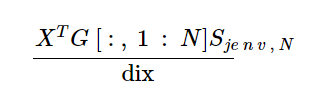

In [25]:
## Projecting vectors onto factor space. 
X_pjn = []
for i in np.arange(0,6):
    X_pjn.append(np.dot(X.iloc[i],G[:,:4])/S[:4]/10)
    
X_pjn = np.asarray(X_pjn)

## The projection can also be computed using vectorized form,
X_pjn = Matrix_mult(X.values,G[:,:4])/S[:4]/10
X_i = -Matrix_mult(i_sup,G[:,:4])/S[:4]/10



In [26]:
fs, cos = 'Factor score','Squared cosines'
table3 = pd.DataFrame(columns=['W1','W2','W3','W4','W5','W6'], index=pd.MultiIndex
                      .from_product([[fs, cos], range(1, 3)]))

#table3.loc[fs,    :] = mca_ind.fs_r(N=2).T
#table3.loc[cos,   :] = mca_ind.cos_r(N=2).T
#table3.loc[cont,  :] = mca_ind.cont_r(N=2).T * 1000

fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=X.index, index=pd.MultiIndex.from_product([[fs, cos], range(1, 5)]))

table3.loc[fs,    :] = X_pjn[:,:4].T
table3.loc[cos,   :] = CosDist_r.T

np.round(table3.astype(float), 2)

Wine                 W1    W2    W3    W4    W5    W6
Factor score    1 -0.95  0.79  1.02  0.95 -1.02 -0.79
                2 -0.32  0.63 -0.32 -0.32 -0.32  0.63
                3  0.43  0.39  0.10 -0.43 -0.10 -0.39
                4 -0.10  0.18 -0.23  0.10  0.23 -0.18
Squared cosines 1  0.75  0.52  0.86  0.75  0.86  0.52
                2  0.08  0.33  0.08  0.08  0.08  0.33
                3  0.15  0.12  0.01  0.15  0.01  0.12
                4  0.01  0.03  0.04  0.01  0.04  0.03

D'après les projections factorielles, il est clair que les valeurs du premier facteur sont négatives pour le baril 1, et positives pour le baril 2. Ceci est mieux illustré dans la figure ci-dessous. Les scores pour le vin inconnu sont représentés par le point bleu. Sur la base de ces notes, il n'est pas possible d'attribuer avec précision le vin nouveau à l'un des deux barriques.


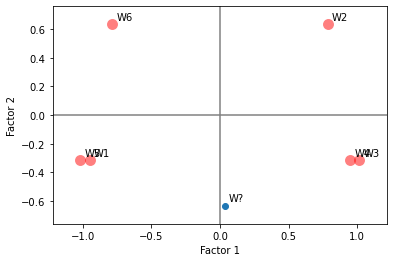

In [27]:

points = table3.loc[fs].values
labels = table3.columns.values

plt.figure()
plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(X_pjn[:,0],X_pjn[:,1], marker='o',s=120, color='r', alpha=.5, linewidths=0)
i = 0
for label in X.index:
    x = X_pjn[i,0]
    y = X_pjn[i,1]
    plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
    i +=1
plt.scatter(X_i[0],X_i[1])
plt.annotate('W?', xy=(X_i[0],X_i[1]), xytext=(X_i[0] + .03, X_i[1] + .03))
    
plt.show()

## 3. Tutoriel rapide sur le package MCA.
Nous allons maintenant appliquer le package MCA en python pour effectuer les mêmes calculs.



In [28]:
from mca import *

data = pd.read_table('burgundies.csv',
                     sep=',', skiprows=1, index_col=0, header=0)
X = data.drop('oak_type', axis=1)
j_sup = data.oak_type
i_sup = np.array([0, 1, 0, 1, 0, .5, .5, 1, 0, 1, 0, 0, 1, 0, .5, .5, 1, 0, .5, .5, 0, 1])
ncols = 10

Les calculs MCA sont implémentés via l'objet MCA. La condition par défaut applique la correction Benzécri pour les valeurs propres, par conséquent, l'indicateur Benzecri doit être défini sur false. Vous trouverez ci-dessous la liste des attributs de la fonction MCA, - .L Valeurs propres - .F Scores des facteurs pour les colonnes. (les composants sont une combinaison linéaire de colonnes) - Scores de facteur .G pour les lignes. (les composants sont une combinaison linéaire de lignes) - .expl_var Variance expliquée. - Les projections .fs_r sur l'espace des facteurs peuvent également être calculées en appliquant fs_r_sup sur chacun des éléments de la ligne. - .cos_r Distance cosinus entre le vecteur $i^{th}$ et le facteur $j^{th}$ (ou vecteur propre ligne) - .cont_r Contribution de la variable catégorielle individuelle au facteur.

In [29]:
mca_ben = MCA(X, ncols=ncols)
mca_ind = MCA(X, ncols=ncols, benzecri=False)
data = {'Iλ': pd.Series(mca_ind.L),
        'τI': mca_ind.expl_var(greenacre=False, N=4),
        'Zλ': pd.Series(mca_ben.L),
        'τZ': mca_ben.expl_var(greenacre=False, N=4),
        'cλ': pd.Series(mca_ben.L),
        'τc': mca_ind.expl_var(greenacre=True, N=4)}

# 'Indicator Matrix', 'Benzecri Correction', 'Greenacre Correction'
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=data, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Factor'

table2

,Iλ,τI,Zλ,τZ,cλ,τc
Factor,,,,,,
1,0.85321,0.71101,0.70040,0.98229,0.70040,0.95189
2,0.20000,0.16667,0.01235,0.01731,0.01235,0.01678
3,0.11511,0.09593,0.00028,0.00040,0.00028,0.00038
4,0.03168,0.02640,0.00000,0.00000,0.00000,0.00000
Σ,1.20000,1.00000,0.71303,1.00000,0.71303,0.96905


Ensuite, nous utiliserons des fonctions dans MCA pour calculer les projections sur les facteurs importants, la distance cosinusoïdale et les contributions des termes individuels aux facteurs.


In [30]:

fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=X.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))

table3.loc[fs,    :] = mca_ben.fs_r(N=2).T
table3.loc[cos,   :] = mca_ben.cos_r(N=2).T
table3.loc[cont,  :] = mca_ben.cont_r(N=2).T * 1000
table3.loc[fs, 'W?'] = mca_ben.fs_r_sup(pd.DataFrame([i_sup]), N=2)[0]

np.round(table3.astype(float), 2)

Wine                        W1      W2      W3      W4      W5      W6    W?
Factor score         1    0.86   -0.71   -0.92   -0.86    0.92    0.71  0.03
                     2    0.08   -0.16    0.08    0.08    0.08   -0.16 -0.63
Squared cosines      1    0.99    0.95    0.99    0.99    0.99    0.95   NaN
                     2    0.01    0.05    0.01    0.01    0.01    0.05   NaN
Contributions x 1000 1  176.68  120.99  202.33  176.68  202.33  120.99   NaN
                     2   83.33  333.33   83.33   83.33   83.33  333.33   NaN

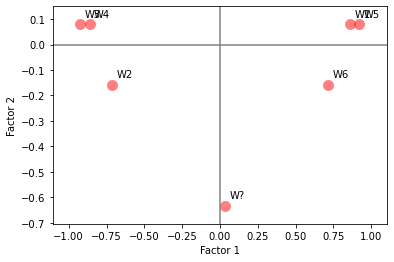

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

points = table3.loc[fs].values
labels = table3.columns.values

plt.figure()
plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(*points, s=120, marker='o', c='r', alpha=.5, linewidths=0)
for label, x, y in zip(labels, *points):
    plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
plt.show()

## 4. Conclusion
Dans cet exemple, l'analyse des correspondances multiples, une analyse en composantes principales comme la technique pour les données catégorielles est présentée. Tout d'abord, la méthode MCA a été présentée en utilisant du code python, puis le package MCA a été introduit. Dans le prochain exercice, vous appliquerez cette technique à un problème plus complexe d'identification des étudiants à risque à partir de données démographiques et comportementales.